# Generating Names with Bigrams
<!-- Basic Bigram Generator -->

## Table of Contents
1) [Project Overview](#overview)
2) [Preparing the Data](#data)
3) [Building the Bigram Model](#model)
4) [Training the Model](#training)
5) [Generating Names](#generate)
6) [Next Steps](#next)

<a id="overview"></a>
## Project Overview 
The goal of this project is to create a simple language model that can generate names resembling real ones from its training data.

We'll use a neural network trained on character-level bigrams -- that is, pairs of consecutive letters. When the model is given a letter as input, it should predict the probability of each possible next letter. We can then use these probabilities to pick the next letter in a name, then feed that new letter back into the model to continue generating the name, one letter at a time.

<a id="data"></a>
## Preparing the Data
We'll start by reading in a list of names we will use to train our model.

In [1]:
# Create a list of each name in names.txt
names = open("names.txt", "r").read().splitlines()
print(f"Displaying the first three names: {names[:3]}")

Displaying the first three names: ['emma', 'olivia', 'ava']


Now that we have our data, let's split it into bigrams so the model can learn common letter patterns in names. We also want it to learn how each name starts and ends, so let's indicate the start and end of a name with a ".". Below shows an example of the bigrams in the name Emma.

In [2]:
# Break "emma" into bigrams, including "." for start and end.
print(f"Bigrams for emma: {list(zip('.emma', 'emma.'))}")

Bigrams for emma: [('.', 'e'), ('e', 'm'), ('m', 'm'), ('m', 'a'), ('a', '.')]


To use these bigrams in our neural network, we'll organize them into two tensors: X (inputs) and y (labels).
- X will contain the first letter of each bigram. These are the inputs we'll feed into the model.
- y will contain the second letter of each bigram, i.e., the letter that follows each input letter in X. These are the labels or "targets" the model should learn to predict.

To start off, let's import Pytorch.

In [3]:
import torch    # Tensors and backpropagation.

Since PyTorch tensors can't contain character elements, let's assign each letter to an integer value.

In [4]:
import string

# For each letter + ".", add them to dict with an integer value.
stoi = {char:int_val for (int_val, char) in enumerate("." + string.ascii_lowercase)}
print(stoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


We'll also want a way to go backwards, turning numbers back into letters.

In [5]:
itos = {num: letter for letter, num in stoi.items()}
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


Now we are ready to split all the names into bigrams.

In [6]:
X = [] # First letters in bigrams
y = [] # X's bigram pairs.

for name in names:
    for char1, char2 in zip("." + name, name + "."):
        # Convert chars to ints so we can later add to tensors.
        X.append(stoi[char1])
        y.append(stoi[char2])

print(f"Our training data has {len(X)} examples.")
print(f"The first 10 values in X are {X[:10]}.")
print(f"The first 10 values in y are {y[:10]}.")

# Convert list to a tensor.
X = torch.tensor(X)
y = torch.tensor(y)

Our training data has 228146 examples.
The first 10 values in X are [0, 5, 13, 13, 1, 0, 15, 12, 9, 22].
The first 10 values in y are [5, 13, 13, 1, 0, 15, 12, 9, 22, 9].


Before we can use these values in a neural network, we'll need to alter them a bit more. See, neural networks contain weights which get multiplied by each input. Right now our inputs are just numbers from 0 to 26. It wouldn't be very helpful to do math with these inputs, since we want each letter to be treated equally. "z" shouldn't have a different multiplier than "a", for example.

To make sure each input gets treated equally, we can use one-hot encoding. With one-hot encoding, each letter gets represented by an array of length 27 (one for each possible letter including "."). This array contains all 0s apart from a single 1 at the index signifying the chosen letter. To show this more visually, let's explore the one-hot encoded version of the letter "c".

In [7]:
# Get number used to represent c. This will be the index of the 1 after one-hot encoding.
c_index = stoi["c"]

# Create the one-hot encoded representation of the letter "c".
c_enc = torch.zeros(27)
c_enc[c_index] = 1

print(f"c's index is {c_index}, so its one-hot encoding looks like {c_enc}")

c's index is 3, so its one-hot encoding looks like tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


Let's apply this encoding to all the letters in our input data. Rather than encoding them all manually like above, we'll use PyTorch's one_hot() function. 

In [8]:
import torch.nn.functional as F

# One-hot encode X to turn each letter into an array of length 27 (one index for each possible letter including ".".)
X_enc = F.one_hot(X, num_classes = 27)
# View encodings for first 5 letters.
X_enc[:5]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

As you can see, the values here are all integers. To later multiply them by the float weights in our neural network, we'll need to convert those values into floats.

In [9]:
# We want the neural net to produce floats, so the inputs must be floats as well.
X_enc = X_enc.float()
# The first letter should now be encoded with floats.
X_enc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

<a id="model"></a>
## Building the Bigram Model

For this project, we'll use a very simple neural network with only a single layer of neurons. 

Before we jump into building this layer, it's important to understand how a single neuron works.

Since each letter in X now has a length of 27 (due to the encoding), this one neuron will need 27 weights so each element in the inputs can be multiplied by a unique weight. The weights will start off as random numbers from a normal distribution. (After training the model, these numbers should become more meaningful.)

In [10]:
# Weights start off random, so let's use a generator.
gen = torch.Generator().manual_seed(42)

# A single neuron with one weight for each element in our input.
W = torch.randn((27, 1), generator=gen)
print("Here is a single neuron with a 27 weights:")
print(W)

Here is a single neuron with a 27 weights:
tensor([[ 1.9269],
        [ 1.4873],
        [ 0.9007],
        [-2.1055],
        [ 0.6784],
        [-1.2345],
        [-0.0431],
        [-1.6047],
        [-0.7521],
        [ 1.6487],
        [-0.3925],
        [ 0.2415],
        [-1.1109],
        [ 0.0915],
        [-2.3169],
        [-0.2168],
        [-1.3847],
        [-0.8712],
        [-0.2234],
        [-0.6216],
        [-0.5920],
        [-0.0631],
        [-0.8286],
        [ 0.3309],
        [-1.5576],
        [ 0.9956],
        [-0.8798]])


Now we can use this neuron by multiplying our inputs with it.


When the input is a one-hot encoded vector, the dot product multiplies all weights by 0 except for the one weight at the position where the input has a 1. Each of the resulting multiplications are then added together, but since most of the values are 0, they end up ignored by the result. Thus, it is as if each one-hot encoded input simply selects the corresponding weight from the neuron and ignores the rest.

In [11]:
print("c_enc has a 1 at index 3, so the dot product should select the neuron's weight at index 3.")
c_enc @ W

c_enc has a 1 at index 3, so the dot product should select the neuron's weight at index 3.


tensor([-2.1055])

As described earlier, we want our model to take a letter as input and output the probability of each possible next letter. Since there are 27 possible next letters, the model should produce a vector of 27 probabilities, one for each letter.

We've seen that a single neuron produces one output. Thus, to produce 27 outputs, we'll need a layer of 27 neurons.

In [12]:
# Resetting generator so cell always gives same numbers instead of generating the next numbers.
gen = torch.Generator().manual_seed(42)

# Each column in the weights matrix represents another neuron in the layer.
W = torch.randn((27, 27), generator = gen, requires_grad=True)    # `requires_grad` will be explained later.

Now W (our weights) is a 27x27 matrix of random values from a normal distribution. Each column represents a single neuron in the layer. 

Before we explored how one-hot encoding selected a single value from the neuron. That's still true, but now that there are 27 neurons, it will select the value in that same row for each of the neurons. So for example, an input of c (index 3) dot producted with the layer would result in a vector of all the weights at the row with index 3.

In [13]:
# Select the third weight from each neuron.
c_output = c_enc @ W
c_output

tensor([-0.3387, -1.3407, -0.5854,  0.5362,  0.5246,  1.1412,  0.0516,  0.7440,
        -0.4816, -1.0495,  0.6039, -1.7223, -0.8278,  1.3347,  0.4835, -2.5095,
         0.4880,  0.7846,  0.0286,  0.6408,  0.5832,  1.0669, -0.4502, -0.1853,
         0.7528,  0.4048,  0.1785], grad_fn=<SqueezeBackward4>)

Now we have a model that can take a letter as input and produce 27 outputs, one for each possible next letter. 

You may notice that the numbers in our output don't look very much like probabilities just yet. At this stage, the outputs are just raw scores (also called "logits"), not probabilities. When we use this model during training and sampling, we'll need to normalize these outputs to turn them into probabilities. 

In [14]:
print("Our untrained model's current raw scores for each letter following 'c':")
for letter, logit in zip(stoi.keys(), c_output):
    print(f"{letter}: {logit:.4f}")

Our untrained model's current raw scores for each letter following 'c':
.: -0.3387
a: -1.3407
b: -0.5854
c: 0.5362
d: 0.5246
e: 1.1412
f: 0.0516
g: 0.7440
h: -0.4816
i: -1.0495
j: 0.6039
k: -1.7223
l: -0.8278
m: 1.3347
n: 0.4835
o: -2.5095
p: 0.4880
q: 0.7846
r: 0.0286
s: 0.6408
t: 0.5832
u: 1.0669
v: -0.4502
w: -0.1853
x: 0.7528
y: 0.4048
z: 0.1785


Now that we understand what happens when we use a single letter as input to our neural network, let's look at what happens with the full dataset. Our input data, stored in `X_enc`, contains far more than just one letter. When we pass these inputs through the network, each one-hot encoded row in `X_enc` selects a corresponding row from the weights matrix to produce its logits. These logits are then stacked together, resulting in an output matrix where each row contains the logits for one input letter.

In [15]:
# Get logits for each letter in X.
logits = X_enc @ W
logits

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  1.2791,  1.2964,  0.6105],
        [ 0.5760,  1.1415,  0.0186,  ...,  0.8123, -1.9006,  0.2286],
        [-0.3303, -0.7939,  0.3752,  ...,  0.6854, -0.1397, -1.1808],
        ...,
        [-1.1798, -0.5297,  0.9625,  ..., -0.7068, -1.2520,  3.0250],
        [ 1.3463,  0.8556,  0.3220,  ..., -1.4740, -0.3502,  0.4590],
        [ 0.4557,  0.2503, -1.3611,  ...,  2.1296, -1.5181,  0.1387]],
       grad_fn=<MmBackward0>)

### Turning Logits to Probabilities with Softmax

Earlier, we mentioned that we'd like to turn these logits into probabilities. We can do this using the softmax function, which works like so:

First, we exponentiate each of the logits. This turns all values positive while keeping their relative order. All negative numbers will turn into a value between 0 and 1, and all positive values will end up as some value larger than 1.

In [16]:
# Change values to all be positive.
pos_values = logits.exp()
pos_values

tensor([[ 6.8683,  4.4251,  2.4614,  ...,  3.5935,  3.6562,  1.8413],
        [ 1.7789,  3.1315,  1.0187,  ...,  2.2532,  0.1495,  1.2568],
        [ 0.7187,  0.4521,  1.4553,  ...,  1.9845,  0.8696,  0.3070],
        ...,
        [ 0.3074,  0.5888,  2.6183,  ...,  0.4932,  0.2859, 20.5950],
        [ 3.8430,  2.3528,  1.3799,  ...,  0.2290,  0.7045,  1.5825],
        [ 1.5773,  1.2844,  0.2564,  ...,  8.4117,  0.2191,  1.1488]],
       grad_fn=<ExpBackward0>)

Then we turn this into a probability by summing up each row and setting each logit in that row equal to their fraction of that sum. 

In [17]:
# Sum the column vectors to calculate the sum of each row, then divide each element in the row by the result to get their probabilities.
probs = pos_values / pos_values.sum(dim=1, keepdims=True)
probs

tensor([[0.1230, 0.0793, 0.0441,  ..., 0.0644, 0.0655, 0.0330],
        [0.0396, 0.0698, 0.0227,  ..., 0.0502, 0.0033, 0.0280],
        [0.0123, 0.0078, 0.0250,  ..., 0.0340, 0.0149, 0.0053],
        ...,
        [0.0044, 0.0085, 0.0378,  ..., 0.0071, 0.0041, 0.2970],
        [0.0843, 0.0516, 0.0303,  ..., 0.0050, 0.0154, 0.0347],
        [0.0435, 0.0354, 0.0071,  ..., 0.2319, 0.0060, 0.0317]],
       grad_fn=<DivBackward0>)

If we did softmax correctly, each row should now add up to 1.

In [18]:
# Confirm that each row now sums to 100%.
probs.sum(dim=1, keepdims=True)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        ...,
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<SumBackward1>)

<a id="training"></a>
## Training the Model

Now that we have our model, we're ready to train it. Before we fully train the network on all our inputs, let's walk through how it works by training it with a single bigram.

### Demonstration

For this example, we will train the model that when it sees the letter "c", it should output "a". 

In [19]:
# Select weights from W to get logits.
c_logits = c_enc @ W
# Turn logits into probabilities with softmax.
c_pos = c_logits.exp()
c_probs = c_pos / c_pos.sum()
# Examine current probabilities.
c_probs

tensor([0.0188, 0.0069, 0.0147, 0.0451, 0.0446, 0.0827, 0.0278, 0.0556, 0.0163,
        0.0092, 0.0483, 0.0047, 0.0115, 0.1003, 0.0428, 0.0021, 0.0430, 0.0579,
        0.0272, 0.0501, 0.0473, 0.0768, 0.0168, 0.0219, 0.0561, 0.0396, 0.0316],
       grad_fn=<DivBackward0>)

In [20]:
# Check model's current prediction that "a" follows "c".
original_prediction = c_probs[stoi["a"]]

print(f"Before training, the model predicts that 'a' has a {original_prediction * 100:.2f}% chance of following 'c'.")

Before training, the model predicts that 'a' has a 0.69% chance of following 'c'.


That's a very low probability. To train our model, we need a way to evaluate how bad its predictions are so that we can take the necessary steps to fix them. To do this, we use something called a loss function. The goal of an ML model is to minimize the loss. For this model, the loss function we will use is called the Negative Log Likelihood (NLL) loss. Let's break down what that means.

- Likelihood: Multiply together all probabilities for the chosen inputs. For this example, we only have one probability, but usually there will be many. The ideal likelihood is 1, meaning that the model always predicted 100% for the correct outputs.
- Log: Likelihoods can be an incredibly small number, which is hard to work with since computers have limited precision. We'd have less of a small number if we could add the values instead of multiplying them. Log likelihood allows us to do just that, because $log(a*b*c) == log(a) + log(b) + log(c)$, and since log is monotonically increasing, maximizing the log likelihood is equivalent to mazimizing the likelihood, so this convenience doesn't negatively impact the outcome.
- Negative: Likelihood is a number that we want to maximize, but loss is something that should be minimized. If we take the negative of the likelihood, it becomes something we can minimize instead, thus being useable for loss.

We can then normalize that loss by dividing what we get by the total by the number of inputs. Since getting the log of the likelihood allowed us add each of the losses rather than multiplying them, the combination of adding losses and dividing by their count can be combined into a single mean() operation.

In [21]:
# Use NLL loss to evaluate how poorly the model currently performs.
loss = -original_prediction.log().mean()
loss

tensor(4.9747, grad_fn=<NegBackward0>)

A perfect loss would be 0. The loss we got is pretty bad. To improve our model, we'll need to change the weights of our model so they produce more accurate results, thus minimizing the loss. We won't need to change all the weights to improve this one prediction, though. We'll only need to change the weights that had an impact on the loss we got. To determine which weights to change, we use derivatives from calculus. A derivative tells us how much a small change in a variable affects the output of a function. In our case, the function is the loss function, so by calculating the derivative of the loss with respect to each weight, we can see how much each weight contributed to the loss. 

The collection of all these derivatives (one for each weight) is called the gradient. To find the gradient of the loss with respect to each weight, we can use backpropagation. (Remember how we created W with the parameter `requires_grad = True`? That was so we can get its gradient now.) 

In [22]:
# Clear any existing gradient for W.
W.grad = None
# Backpropagate through the network to find out how much each weight impacted the loss.
loss.backward()

Before we examine W's gradient, let's try to think through what we expect it to look like. 

First, let's think about the size. W is size (27, 27). Each of these weights will have a partial derivative, so W.grad should be size (27, 27) as well.

In [23]:
W.grad.size()

torch.Size([27, 27])

Now, what partial derivatives should we expect? Let’s walk through the steps that lead to this loss.

First, we calculated the logits with `c_enc @ W`, which multiplied our one-hot encoded vector `c_enc` (which represents "c" as a 1 at index 3 and 0 elsewhere) by the weights matrix `W`. As discussed earlier, multiplying a one-hot vector by a matrix selects the corresponding row of the matrix, which in this case is row 3, and multiplies each other row by 0. This means that only the weights in row 3 of `W` can have any effect on the loss. Changing the other weights can't impact the loss, since any change would still end up getting multiplied by 0.

As a result, when we look at the gradient, we should expect the partial derivatives to be zero everywhere except for the weights in row 3.

Let's take a look at the gradient now to see if we're on the right track.

In [24]:
W.grad

tensor([[ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0188, -0.9931,  0.0147,  0.0451,  0.0446,  0.0827,  0.0278,  0.0556,
          0.0163,  0.0092,  0.0483,  0.0047,  0.0115,  0.1003,  0.0428,  0.0021

Just as we expected, the only row with non-zero values is the row with index 3. 

The specific values of the partial derivatives in that row were determined by backpropagating through all the operations of the network, which included getting the softmax, selecting the index of "a" to find the model's predicted probability, and getting the Negative Log Likelihood for loss.

Now let's take a closer look at the non-zero row to get more insight.

In [25]:
# Examine the only row with non-zero gradients.
W.grad[3]

tensor([ 0.0188, -0.9931,  0.0147,  0.0451,  0.0446,  0.0827,  0.0278,  0.0556,
         0.0163,  0.0092,  0.0483,  0.0047,  0.0115,  0.1003,  0.0428,  0.0021,
         0.0430,  0.0579,  0.0272,  0.0501,  0.0473,  0.0768,  0.0168,  0.0219,
         0.0561,  0.0396,  0.0316])

Notice how almost all of the weights in this row have a positive partial derivative with respect to the loss. That means that increasing the weights in those positions will increase the loss. We don't want that, since we're trying to minimize the loss. The only weight that has a negative partial derivative with respect to loss (meaning increasing it will decrease the loss) is the weight at index 1. This should make sense, as in this demonstration we specifically were trying to find the probability of the model predicting "a", which would be found at index 1 of the row selected by "c". If we increase that weight, we'd be increasing the probability that the model predicts for "a" following "c", so it makes perfect sense that we'd get a better result and thus decrease the loss.

Now that we have a solid understanding of the gradient, we are ready to use it to improve our model. We do this by nudging each of the weights by some small amount (called the learning rate) in the direction that would decrease loss. Since decreasing the loss means changing the weights in the opposite direction of the gradient, we call this "gradient descent". 

In [26]:
# Nudge each weight in the direction opposite the gradient to minimize loss.
W.data += -0.01 * W.grad

Now that we adjusted the model's weights, let's see if the model is any better at predicting that "a" should come after "c". To do this, we'll need to send our input through the network again.

In [27]:
print(f"Before training, the model predicted that 'a' had a {original_prediction * 100:.2f}% chance of following 'c'.")

# Once again, select weights from W to get logits.
c_logits = c_enc @ W
# Turn logits into probabilities with softmax.
c_pos = c_logits.exp()
c_probs = c_pos / c_pos.sum()
# Check model's current prediction that "a" follows "c".
new_prediction = c_probs[stoi["a"]]

print(f"Now, after adjusting the weights, the model predicts that 'a' has a {new_prediction * 100:.2f}% chance of following 'c'.")

Before training, the model predicted that 'a' had a 0.69% chance of following 'c'.
Now, after adjusting the weights, the model predicts that 'a' has a 0.70% chance of following 'c'.


As we hoped, our model is now a bit better at making predictions. To keep training, we'd need to calculate the loss again, use the new gradients for gradient descent, and keep repeating this process until the model's predictions stop improving.

### Full training

Now that we've walked through a simple training example, we're ready to train the model on our full training data. We'll just repeat the steps we did above.

In [28]:
def train():
    # Go through the full data several times to keep making improvements.
    for _ in range(100):
        ### Forward pass. ###

        # Select row for each letter in X.
        logits = X_enc @ W
        # Use softmax function to turn logits into percents.
        pos = logits.exp()
        probs = pos / pos.sum(dim=1, keepdims=True)
        # For each row of probs, check model's prediction for label.
        predictions = probs[torch.arange(X_enc.size(0)), y]
        # Use NLL loss.
        loss = -predictions.log().mean()

        ### Backwards pass. ###

        # Reset gradients.
        W.grad = None
        # Backpropagate through full network.
        loss.backward()
        # Adjust weights by learning rate to improve loss.
        W.data += -50 * W.grad
        
        
    # Return loss after training so we can check model progress.
    return loss.item()

In [29]:
print("Checking model progress every 100 training iterations.")
for _ in range(10):
    print(f"Loss = {train()}")

Checking model progress every 100 training iterations.
Loss = 2.473177194595337
Loss = 2.4626121520996094
Loss = 2.459376335144043
Loss = 2.45784330368042
Loss = 2.4569640159606934
Loss = 2.456400156021118
Loss = 2.4560108184814453
Loss = 2.4557266235351562
Loss = 2.4555113315582275
Loss = 2.4553422927856445


As we keep training the model, the loss will continue to decrease until the model reaches a point where it can't improve anymore. However, since training on so much data is slow, we'll stop improving the model for now and start using it to generate new, never-before-seen names!

<a id="generate"></a>
## Generating Names

Now we're ready to use this newly trained model to generate names of its own. Remember how earlier we taught our model that each name starts after a "." character? This will finally come in handy here. To start generating a name, we'll feel the network the "." character as input. Our newly trained model should have learned which letters are most likely to follow ".", and thus should know what letters tend to start names. If we input "." into the model now, we can see this for ourselves.

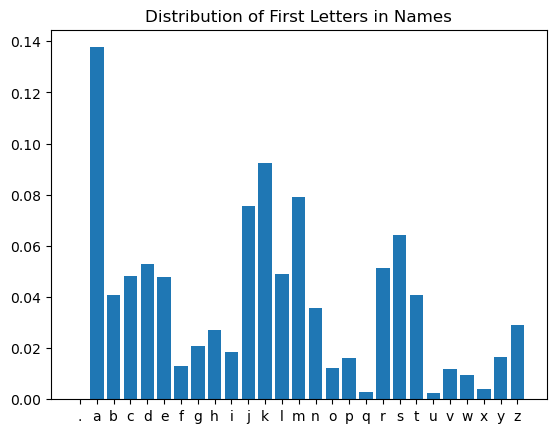

In [30]:
import matplotlib.pyplot as plt    # For displaying results.


# Encode "." to use it as input for our model.
encoded = F.one_hot(torch.tensor(stoi["."]), num_classes=27).float()

# Input "." into our model.
logits = encoded @ W
probs = logits.exp() / sum(logits.exp())    # Softmax on one line.


# Display model's output.
plt.bar(stoi.keys(), probs.tolist())
plt.title("Distribution of First Letters in Names")
plt.show()

It seems our model learned from the data that "a" is a very likely first letter, followed by "k". We can now use multinomial sampling to select a letter based on the weights in this distribution. This gives the model some randomness while still taking the probability of each letter into account. Let's try it now.

In [51]:
gen = torch.Generator().manual_seed(42)

# Sample a first letter for a name 5 times.
letter_indices = torch.multinomial(probs, num_samples=5, replacement=True, generator=gen).tolist()

# Turn the indices of those letters into the actual letters.
for index in letter_indices:
    print(itos[index])

a
a
a
a
k


Those results perfectly demonstrate how the sampling works. Since "a" is so likely to follow ".", it chose "a" four times, but we can see that it has leeway to pick other letters as well. Making the model generate a full name is the same process as making it generate the first letter. Once it generates the first letter, we send that letter through the model and select from *it's* outputs to produce a next letter, and on and on until the model finally selects a ".", indicating the end of a name. 

Now we're ready to generate some names!

In [67]:
gen = torch.Generator().manual_seed(42)


def generate_name():
    name = []
    
    # Start with 0 (".") to find first letter of name.
    letter_idx = 0

    while True:
        # Encode the letter to use in model.
        encoded = F.one_hot(torch.tensor(letter_idx), num_classes=27).float()

        # Send letter through model.
        logits = encoded @ W
        probs = logits.exp() / sum(logits.exp())

        # Sample next letter of the name.
        letter_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=gen).item()

        # If the letter selected is ".", we've finished the name.
        if letter_idx == 0:
            return "".join(name).capitalize()
        
        # Otherwise, add the new letter to the name.
        name.append(itos[letter_idx])
        

In [68]:
# Generate 10 names.
for _ in range(10):
    print(generate_name())

Ya
Syahavilin
Dleekahmangonya
Tryahe
Chen
Ena
Da
Amiiae
A
Keles


Most of these generated names are pretty bad, but that is to be expected from such a simple model that relies only on bigrams. Interestingly, one name generated was Chen, which happens to be the name of a close friend of mine. 

A satisfying end to a fun, simple neural network exploration.

<a id="next"></a>
## Next Steps

This basic name generator was only the beginning. Next time, we'll walk through train/dev/test splits, hidden layers, and more. Stay tuned!